<h1><font size = "+6"> <b>House Price Predictor</b></font></h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import math
sns.set()
# plt.style.use("dark_background")
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("house-prices-advanced-regression-techniques\\train.csv")

In [3]:
test_df = pd.read_csv("house-prices-advanced-regression-techniques\\test.csv")

In [4]:
# Helper Functions -- Jump to code cell below
def get_scatterplot(var, col = 10, row = 7):
    plt.figure(figsize=(col, row))
    data = pd.concat([df[var], df[target]], axis = 1)
    sns.scatterplot(data = data, x = var, y = target)

def get_boxplot(x, y = None, col = 10, row = 7):
    plt.figure(figsize=(col, row))
    data = pd.concat([df[x], df[target]], axis = 1)
    if y == None:
        sns.boxplot(data = data, x = x)
    else:
        sns.boxplot(data = data, x = x, y = y)

def get_heatmap(correlations, theme = "bwr", col = 15, row = 15, round_off = 1, annot = False):
    plt.figure(figsize=(col, row))
    round_off = str(round_off)
    sns.heatmap(correlations, square = True, cmap = theme, fmt = "." + round_off + "f", annot = annot, center = 0, linecolor ="white")

def get_correlated(k = 10, plot = True, theme = "bwr", col = 15, row = 15, round_off = 1, annot = False):
    cols = df.corr().nlargest(k, target)[target]
    if plot:
        get_heatmap(df[cols.index].corr(), theme, col, row, round_off, annot)
    return cols

def get_pairplot(vars, col = 15, row = 15, size = 2.5):
    plt.figure(figsize=(col, row))
    sns.pairplot(df[vars], size = size)

# Set kde = False to disable line.
def get_distplot(var, kde = True, fit = None):
    sns.distplot(df[var], kde = kde, fit = fit)
    return {"Skewness" : df[var].skew(), "Kurtosis" : df[var].kurt()}

# Returns categorical cols, numeric cols, and labelled dataframe consisting of both.
def identify_columns():
    categorical = [col for col in df.columns if df[col].dtype == 'O']
    numeric = [col for col in df.columns if df[col].dtype != 'O']
    data = pd.concat([pd.Series(categorical, name="categorical"), pd.Series(numeric, name = "numeric")], axis=1)
    return categorical, numeric, data


# Returns boolean (whether condition exists), chi square statistic, p-value, critical value.
def chi_square(col1, col2):
    table = pd.crosstab(index = col1, columns=col2)
    expected_values = stats.chi2_contingency(table)[3]

    x = len(table)
    y = len(table.columns)
    degrees = (x - 1) * (y - 1)
    alpha = 0.05

    chi_square = sum([(o - e) ** 2 / e for o, e in zip(table.values, expected_values)])
    chi_square_statistic = sum(chi_square)

    critical_value = stats.chi2.ppf(q = 1 - alpha, df = degrees)

    p_value = 1 - stats.chi2.cdf(x = chi_square_statistic, df = degrees)

    condition1 = False
    condition2 = False
    if chi_square_statistic>=critical_value:
        condition1 = True
    if p_value<=alpha:
        condition2 = True

    return condition1 & condition2, chi_square_statistic, p_value, critical_value

In [5]:
df.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [6]:
df.shape, test_df.shape

((1460, 81), (1459, 80))

In [7]:
categorical, numeric, column_data = identify_columns()
column_data

,categorical,numeric
0,MSZoning,Id
1,Street,MSSubClass
2,Alley,LotFrontage
3,LotShape,LotArea
4,LandContour,OverallQual
5,Utilities,OverallCond
6,LotConfig,YearBuilt
7,LandSlope,YearRemodAdd
8,Neighborhood,MasVnrArea
9,Condition1,BsmtFinSF1


# Exploratory Data Analysis

### Analyzing Sales Price - target variable

In [8]:
target = "SalePrice"
df[target].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

{'Skewness': 1.8828757597682129, 'Kurtosis': 6.536281860064529}

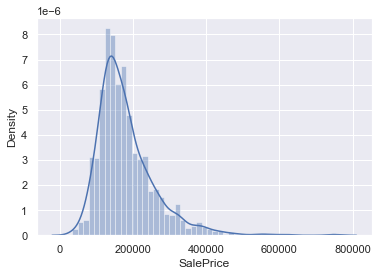

In [9]:
get_distplot(target, True)

#### Examining Relationships with SalePrice

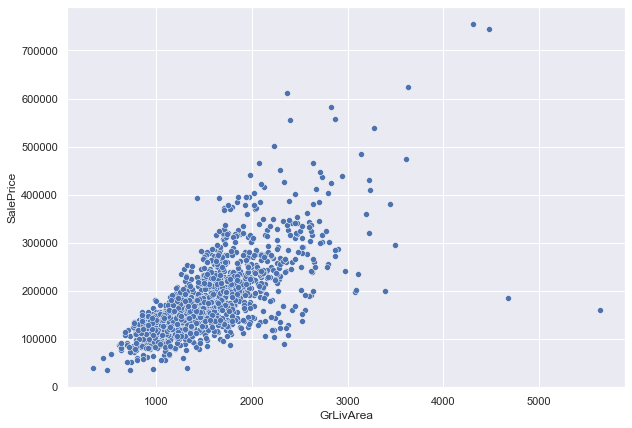

In [10]:
#GrLivArea
get_scatterplot("GrLivArea")

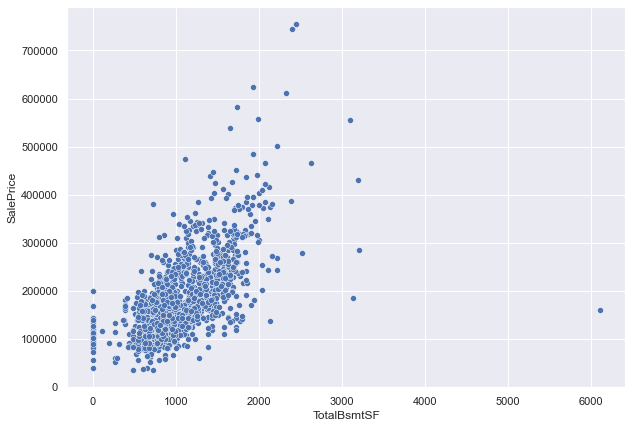

In [11]:
# TotalBsmtSF
get_scatterplot("TotalBsmtSF")

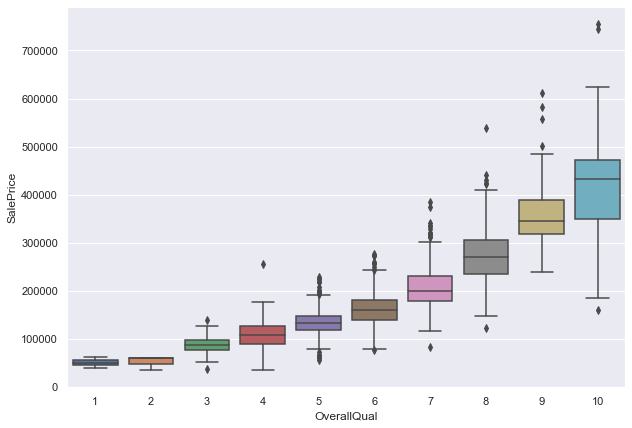

In [12]:
get_boxplot(x = "OverallQual", y = target)

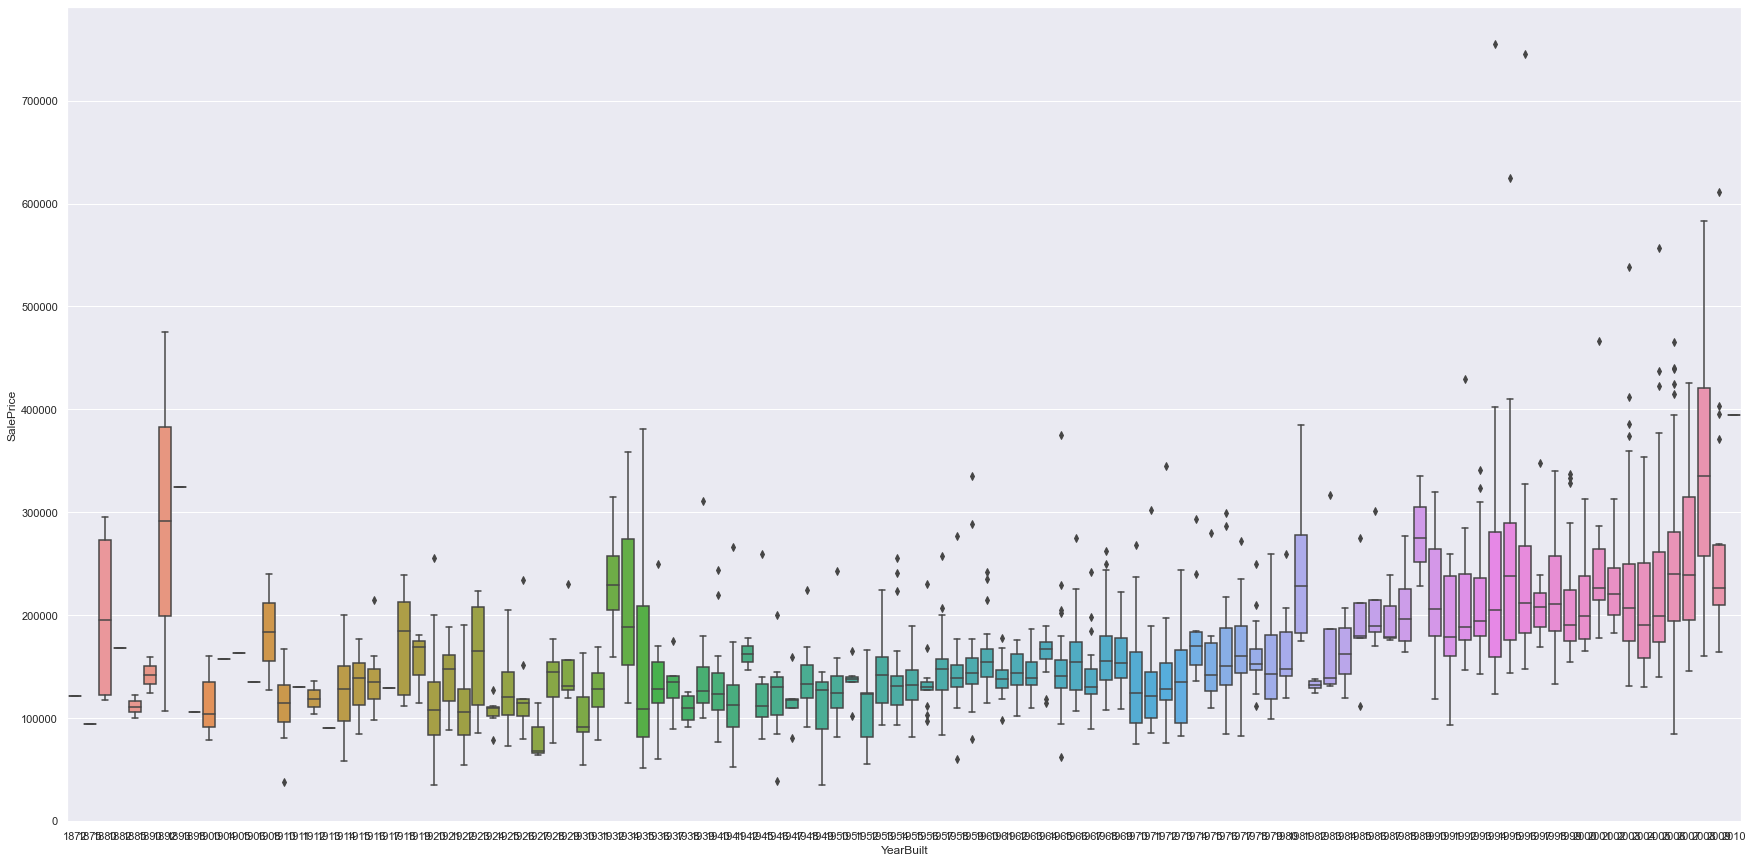

In [13]:
get_boxplot(x = "YearBuilt", y = target, col=30, row=15)

## Discrete Variable Heatmap analysis

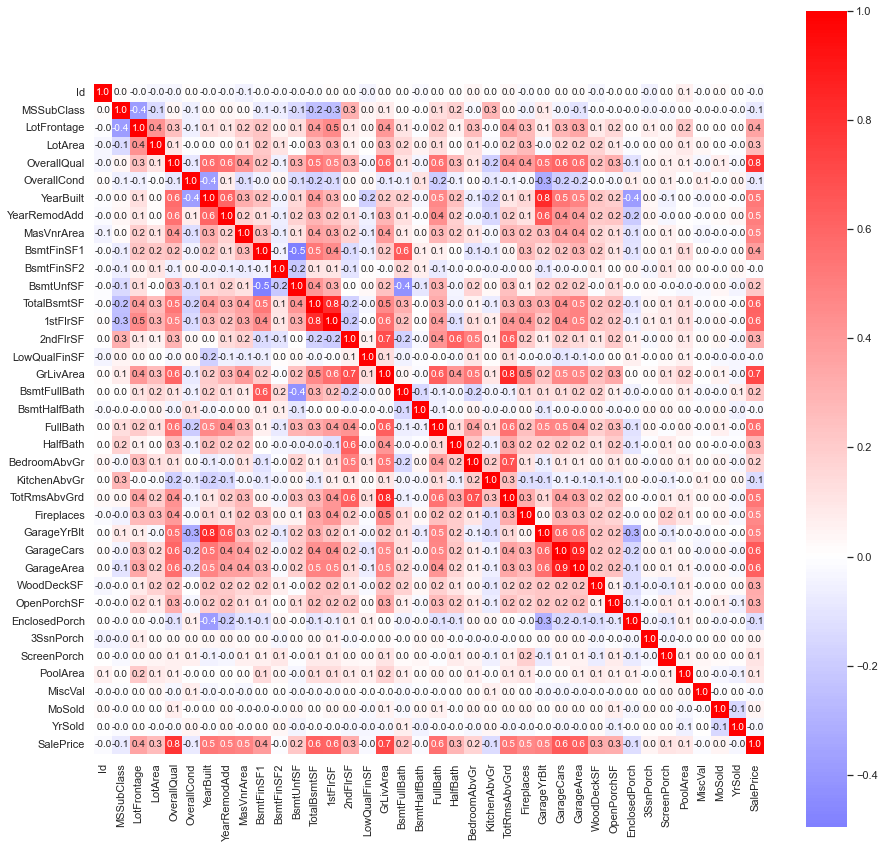

In [14]:
get_heatmap(df.corr(), annot=True)

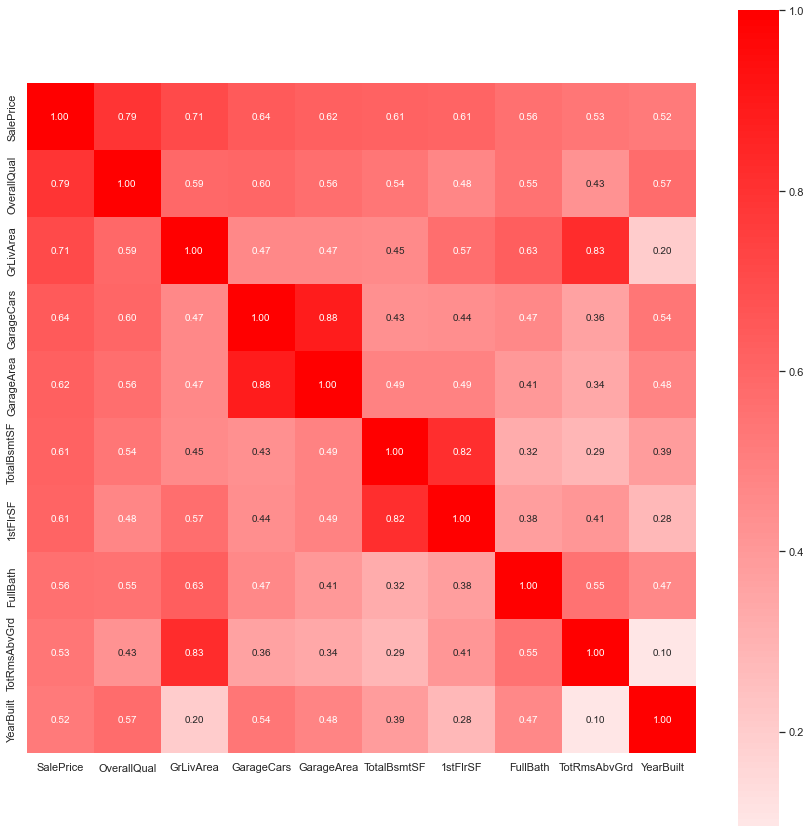

In [15]:
discrete_high_corr = get_correlated(annot=True, round_off=2)

<Figure size 1080x1080 with 0 Axes>

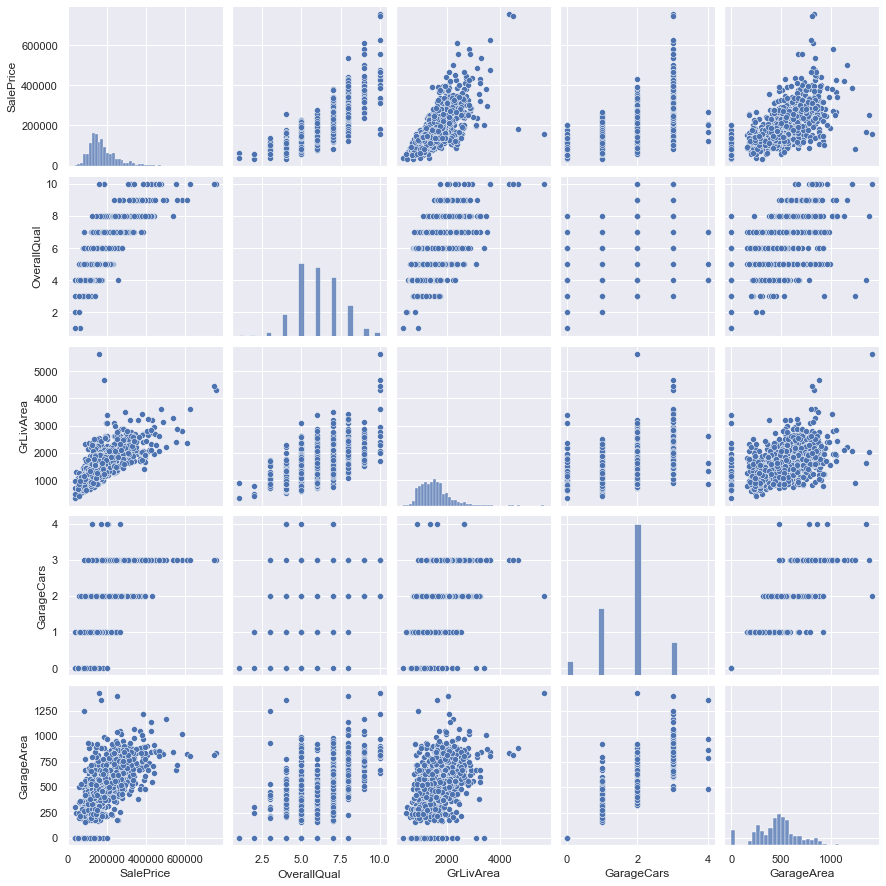

In [16]:
get_pairplot(discrete_high_corr.index.tolist()[: 5])

## Missing Data

#### Combining Test and Train Dataset.

In [17]:
# Combining Both the dataframes, as any transformation we apply (on non-target columns)
# must be applied to both train and test.
ntrain = df.shape[0]
ntest = test_df.shape[0]
y_train = df["SalePrice"]
df.drop(columns = "SalePrice", inplace = True)
df = pd.concat([df, test_df])
print("Combined Dimensions are {}".format(df.shape))
print("y_train dimensions are {}".format(y_train.shape))
df.head(5)

Combined Dimensions are (2919, 80)
y_train dimensions are (1460,)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [18]:
# Let's check how bad it is...
total = df.isnull().sum().sort_values(ascending=False)
percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) * 100

missing_data = pd.concat([total, percentage], axis=1, keys=["Total", "% Missing"])
missing_data.head(20)

,Total,% Missing
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


In [19]:
# replacing na with appropriate values where na doesn't mean "data not available"
df["PoolQC"] = df["PoolQC"].fillna("None") # na means no pool
df["MiscFeature"] = df["MiscFeature"].fillna("None") # na means no misc feature
df["Alley"] = df["Alley"].fillna("None") # na means no misc feature
df["Fence"] = df["Fence"].fillna("None") # na means no fence
df["FireplaceQu"] = df["FireplaceQu"].fillna("None") # na means no fireplace

In [20]:
# replacing values for homes without garages.
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

In [21]:
# replacing values for homes without basements.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

In [22]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

In [23]:
# Lot frontage - we can't simply remove this discrete column as it has a high correlation with
# SalePrice (0.4)
df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())

In [24]:
missing_data = [var for var in df.columns if df[var].isnull().sum() > 0]
for var in missing_data:
    if df[var].dtype == 'O':
        df[var] = df[var].fillna(df[var].mode()[0])
    else:
        df[var] = df[var].fillna(df[var].mode()[0])

In [25]:
df.isnull().sum().max()

0

## Outliers

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

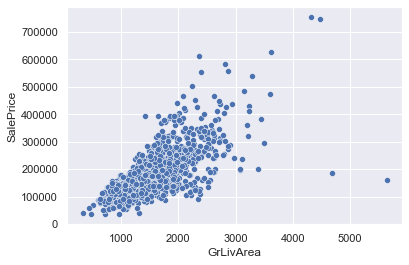

In [26]:
# Let's check GrLivArea
GrLivArea = df.iloc[ : ntrain, df.columns.get_loc("GrLivArea")]
sns.scatterplot(data = pd.concat([GrLivArea, y_train], axis = 1), x = "GrLivArea", y = target)

Outliers Present

In [27]:
df.drop(index = df[df["GrLivArea"] > 4790].index, inplace = True)
df.shape

(2915, 80)

In [28]:
df.drop(columns = "Id", inplace = True)

## Final Changes

In [29]:
#MSSubClass=The building class
df['MSSubClass'] = df['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
df['OverallCond'] = df['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [30]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(df[c].values))
    df[c] = lbl.transform(list(df[c].values))

# shape
print('Shape all_data: {}'.format(df.shape))

Shape all_data: (2915, 79)


In [31]:
# Adding total sq-footage feature
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

## Normalizing Variables

In [32]:
# Let's find the skew for all the numerical features.
numeric = [var for var in df.columns if df[var].dtype != "object"]
skewed = [df[var].skew() for var in numeric]
skewed = pd.Series(skewed, index=numeric, name="Skew").sort_values(ascending=False)
skewed

MiscVal          22.187088
PoolArea         17.691647
LotArea          13.112975
LowQualFinSF     12.086535
3SsnPorch        11.373947
LandSlope         4.973910
KitchenAbvGr      4.301059
BsmtFinSF2        4.144996
EnclosedPorch     4.016257
ScreenPorch       3.945539
BsmtHalfBath      3.944922
MasVnrArea        2.590666
OpenPorchSF       2.507524
WoodDeckSF        1.843429
LotFrontage       1.257289
GrLivArea         1.035419
1stFlrSF          0.982260
BsmtUnfSF         0.919597
2ndFlrSF          0.863401
BsmtFinSF1        0.852159
TotalSF           0.816562
Fireplaces        0.726577
TotRmsAbvGrd      0.713217
HalfBath          0.697532
BsmtFullBath      0.623140
OverallCond       0.569069
HeatingQC         0.484661
TotalBsmtSF       0.443876
FireplaceQu       0.331604
BedroomAbvGr      0.328630
GarageArea        0.210961
OverallQual       0.190278
FullBath          0.169063
MSSubClass        0.140056
YrSold            0.131204
BsmtFinType1      0.083854
GarageCars       -0.218743
Y

In [33]:
# Filtering out variables whose skew is greater than 0.75 (abs)
for (skew, index) in zip(skewed, skewed.index):
    if skew < 0.75:
        skewed.drop(index = index, inplace = True)
skewed

MiscVal          22.187088
PoolArea         17.691647
LotArea          13.112975
LowQualFinSF     12.086535
3SsnPorch        11.373947
LandSlope         4.973910
KitchenAbvGr      4.301059
BsmtFinSF2        4.144996
EnclosedPorch     4.016257
ScreenPorch       3.945539
BsmtHalfBath      3.944922
MasVnrArea        2.590666
OpenPorchSF       2.507524
WoodDeckSF        1.843429
LotFrontage       1.257289
GrLivArea         1.035419
1stFlrSF          0.982260
BsmtUnfSF         0.919597
2ndFlrSF          0.863401
BsmtFinSF1        0.852159
TotalSF           0.816562
Name: Skew, dtype: float64

In [34]:
# applying log transformation to 1 + x.
for var in skewed.index:
    df[var] = np.log1p(df[var])

### Creating Dummy Variables

In [35]:
df = pd.get_dummies(df)

In [36]:
df.shape

(2915, 222)

In [37]:
train = df[:ntrain]
test = df[ntrain:]
y = y_train

# Modelling


### <u>Basic Modelling</u>

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size = 0.2, random_state=1)

### 1. Random Forest Regressor

In [39]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=0)

In [40]:
y_pred = regressor.predict(X_test)

#### Analysing results

In [41]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Random Forest Results\n')

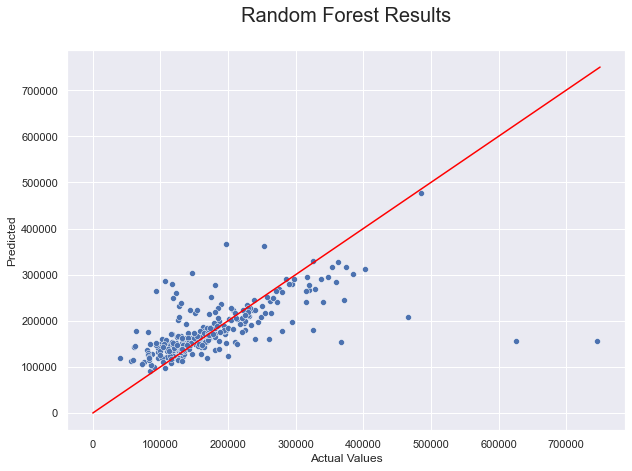

In [42]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000], color = "red")
plt.title("Random Forest Results\n", fontsize = 20)

More <b>distant</b> the points are from the line, more the error.

In [43]:
# Calculating R2 and Adjusted R2
def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

def adj_rsquared(x, y, p):
    r = rsquared(x, y)
    n = len(x)
    return 1 - (((1 - r) * (n - 1))/(n - p - 1))


print("Random Forest Model Got a R-Squared score of {:.2f} and an adjusted R-Squared Score of {:.2f}".format(rsquared(y_test, y_pred), adj_rsquared(y_test, y_pred, X_train.shape[1])))

Random Forest Model Got a R-Squared score of 0.40 and an adjusted R-Squared Score of -1.55


In [44]:
# Calculating RMSE
def mse(x, y):
    mse_score = 0
    for actual, pred, in zip(x, y):
        mse_score += (actual - pred) ** 2
    return mse_score / len(x)
# Calculating MAE
def mae(x, y):
    mae_score = 0
    for actual, pred in zip(x, y):
        mae_score += abs(actual - pred)
    return mae_score / len(x)

# Calculating root means squared of log of errors.
def rmsle(x, y):
    rmsle_score = 0
    for actual, pred in zip(x, y):
        rmsle_score += (np.log1p(actual) - np.log1p(pred)) ** 2
    return math.sqrt(rmsle_score / len(x))

print("Root Mean Squared Error for Random Forest Regression : {}, Mean Squared Error : {}, RMSLE = {}".format(math.sqrt(mse(y_test, y_pred)), mse(y_test, y_pred), rmsle(y_test, y_pred)))
print("Mean Absolute Error : {}".format(mae(y_pred, y_test)))

Root Mean Squared Error for Random Forest Regression : 65706.89854781108, Mean Squared Error : 4317396516.772339, RMSLE = 0.3060261042076823
Mean Absolute Error : 34977.48433561645


### 2. Multiple Linear Regression

In [45]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [46]:
y_pred = lin_reg.predict(X_test)

In [47]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Multiple Linear Regression Results\n')

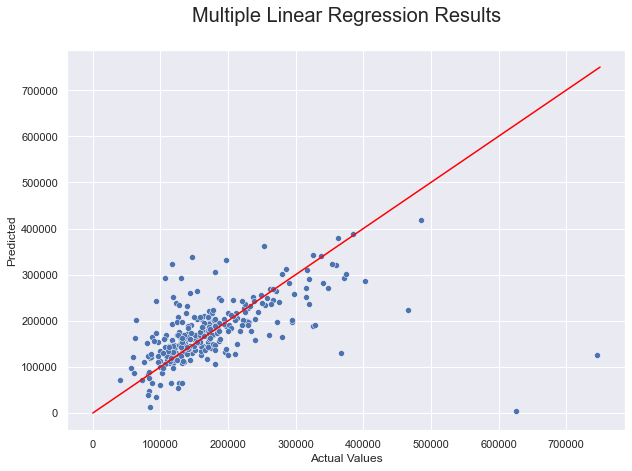

In [48]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Multiple Linear Regression Results\n", fontsize = 20)

In [49]:
print("Multiple Linear Regression Got a R-Squared score of {:.2f} and an adjusted R-Squared Score of {:.2f}".format(rsquared(y_test, y_pred), adj_rsquared(y_test, y_pred, X_train.shape[1])))

Multiple Linear Regression Got a R-Squared score of 0.28 and an adjusted R-Squared Score of -2.02


In [50]:
print("Root Mean Squared Error for Multiple Linear Regression : {} \nMean Squared Error : {}\nRMSLE : {}".format(math.sqrt(mse(y_test, y_pred)), mse(y_test, y_pred), rmsle(y_test, y_pred)))
print("Mean Absolute Error : {}".format(mae(y_pred, y_test)))

Root Mean Squared Error for Multiple Linear Regression : 74143.73307096635 
Mean Squared Error : 5497293153.69871
RMSLE : 0.4488311154053574
Mean Absolute Error : 40518.16119136725


### 3. Polynomial Regression

In [51]:
# first we have to raise the matrix of features to different powers.
from sklearn import preprocessing
poly_reg = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
lin_reg2 = linear_model.LinearRegression()
lin_reg2.fit(X_poly, y_train)

LinearRegression()

In [52]:
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_test))

In [53]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Polynomial Linear Regression Results\n')

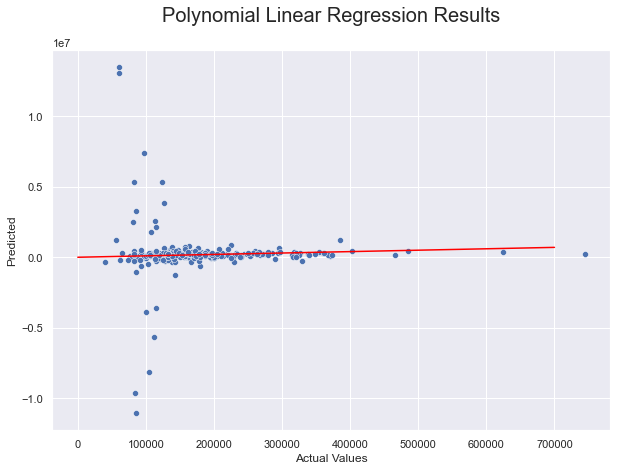

In [54]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 700000], y = [0, 700000],  color = "red")
plt.title("Polynomial Linear Regression Results\n", fontsize = 20)

<font size="+1"> Polynomial Regression is not suited for datasets with such high column count.
I'm actually not sure what happened here, because the number of columns in X_poly can be calculated by :
</font>
<center> features_poly = degree ** features_linear </center>
<font size="+1">
which in this case = 2 ** (200 +) which is basically infinity. <br>
Not even worth finding accuracy metrics.
</font>

In [55]:
X_poly.shape

(1168, 24976)

### 4. Support Vector Regression

In [56]:
# we need to first standardize our data before applying SVR.
# first we'll select columns which are problematic (values are too high)
problematic_cols = [var for var in train.columns if df[var].max() > 3]

In [57]:
from sklearn import preprocessing
train_svr = train.copy()
scx = preprocessing.StandardScaler()
train_svr[problematic_cols] = scx.fit_transform(train_svr[problematic_cols])

In [58]:
y_svr = y.copy().to_numpy()
sc = preprocessing.StandardScaler()
y_svr = sc.fit_transform(y_svr.reshape(len(y_svr), 1))

In [59]:
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(train_svr, y_svr, test_size = 0.2)

<font size="+1"> Training SVR Model </font>

In [60]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf')
svr_reg.fit(X_train_svr, y_train_svr)

SVR()

In [61]:
y_pred_svr = svr_reg.predict(X_test_svr)
y_pred_svr = sc.inverse_transform(y_pred_svr)

In [62]:
y_test_svr = sc.inverse_transform(y_test_svr.flatten())

In [63]:
predict_data = pd.DataFrame({"Actual Values" : list(y_test_svr.flatten()), "Predicted" : list(y_pred_svr)})

In [64]:
predict_data

,Actual Values,Predicted
0,215000.0,194741.970645
1,127000.0,142711.709752
2,137500.0,164797.045910
3,204900.0,203869.755006
4,60000.0,106097.263177
...,...,...
287,123000.0,248560.580080
288,305900.0,288081.070055
289,185850.0,217334.120279
290,131500.0,155021.346030


Text(0.5, 1.0, 'SVR Regression Results\n')

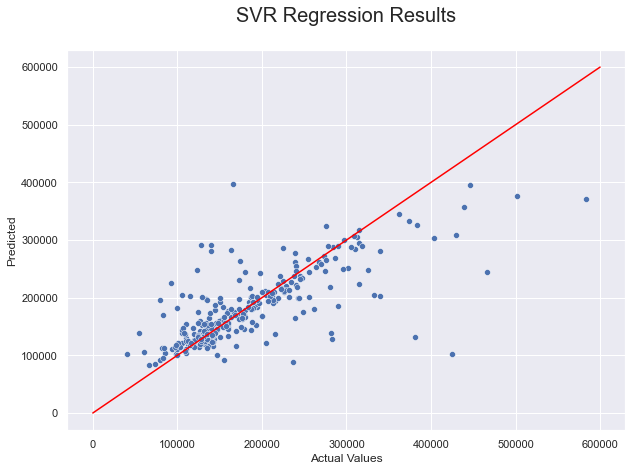

In [65]:
sns.set()
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 600000], y = [0, 600000],  color = "red")
plt.title("SVR Regression Results\n", fontsize = 20)

In [66]:
print("Root Mean Squared Error for Multiple Linear Regression : {} \nMean Squared Error : {}\nRMSLE : {}".format(math.sqrt(mse(y_test_svr, y_pred_svr)), mse(y_test_svr, y_pred_svr), rmsle(y_test_svr, y_pred_svr)))
print("Mean Absolute Error : {}".format(mae(y_test_svr, y_pred_svr)))
print("Multiple Linear Regression Got a R-Squared score of {:.2f} and an adjusted R-Squared Score of {:.2f}".format(rsquared(y_test_svr, y_pred_svr), adj_rsquared(y_test_svr, y_pred_svr, X_train_svr.shape[1])))

Root Mean Squared Error for Multiple Linear Regression : 53402.65418708866 
Mean Squared Error : 2851843474.2257776
RMSLE : 0.2708046815965723
Mean Absolute Error : 30169.30593417981
Multiple Linear Regression Got a R-Squared score of 0.55 and an adjusted R-Squared Score of -0.88


<font size="+2"> <i> Basic regression techinques are resulting in large RMSLE and adj. R-squared errors.
Let's move on to ensemble learning. </i></font>
<hr>
<font size="+1"> Best accuracy achieved with Support Vector Regression and Random Forest Regression. </font>

## <u>Advanced Modelling</u>


In [67]:
# Let's introduce cross-validation.
from sklearn.model_selection import KFold, cross_val_score
def rmse_cv(model, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

def rmsle_cv(model, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=42).get_n_splits(train.values)
    rmsle= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_log_error", cv = kf))
    return (rmsle)

<h3> 5. Lasso Regression </h3>

- Lasso Regression is an improvement over Multiple Linear Regression.
- It tried to reduce overfitting and increase generalization.
- The value of alpha determines the level of generalization. At alpha = 0, Lasso Regression behaves exactly like Multiple Linear Regression.

In [68]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [69]:
top_score, best_alpha = 1000000000, -1
for i in range(340, 351):
    alpha = 0 + (i * 1)
    lasso_reg = make_pipeline(preprocessing.RobustScaler(), Lasso(alpha = alpha, random_state=0))
    score = rmse_cv(lasso_reg, 15).mean()
    if score < top_score:
        top_score, best_alpha = score, alpha

print("Best Score : {}, with alpha : {}".format(top_score, best_alpha))

Best Score : 50076.01941938149, with alpha : 340


<font size = "+1"> Results are best at alpha = 340. Used Binary Search principle to arrive at this value </font>

In [84]:
lasso_reg = make_pipeline(preprocessing.RobustScaler(), Lasso(alpha=340, random_state=0))

In [85]:
lasso_reg.fit(X_train, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=340, random_state=0))])

In [86]:
y_pred = lasso_reg.predict(X_test)

In [87]:
predict_data = pd.DataFrame({"Actual Values" : y_test.values, "Predicted" : y_pred})

Text(0.5, 1.0, 'Lasso Regression Results\n')

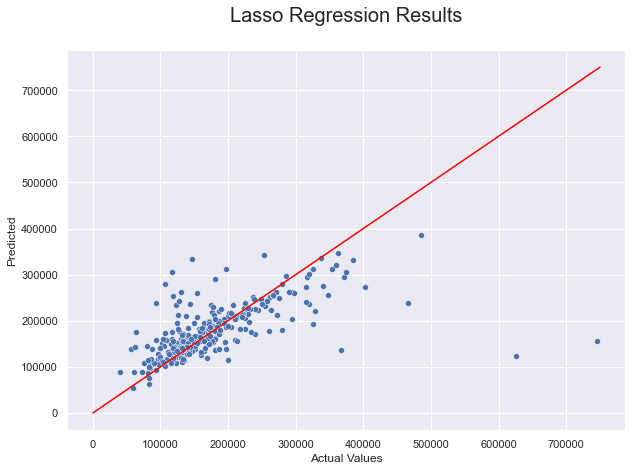

In [88]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted")
sns.lineplot(x = [0, 750000], y = [0, 750000],  color = "red")
plt.title("Lasso Regression Results\n", fontsize = 20)

In [89]:
print("Root Mean Squared Error for Multiple Linear Regression : {} \nMean Squared Error : {}\nRMSLE : {}".format(math.sqrt(mse(y_test, y_pred)), mse(y_test, y_pred), rmsle(y_test, y_pred)))
print("Mean Absolute Error : {}".format(mae(y_test, y_pred)))
print("Multiple Linear Regression Got a R-Squared score of {:.2f} and an adjusted R-Squared Score of {:.2f}".format(rsquared(y_test, y_pred), adj_rsquared(y_test, y_pred, X_train.shape[1])))

Root Mean Squared Error for Multiple Linear Regression : 66043.77465884651 
Mean Squared Error : 4361780171.188496
RMSLE : 0.2972197311116241
Mean Absolute Error : 34661.55757754676
Multiple Linear Regression Got a R-Squared score of 0.39 and an adjusted R-Squared Score of -1.57


<font size="+1"> Lasso Regression got a RMSE of 66000 in test dataset </font>